# Underwriting 

You acquire a small life insurance company. Unfortunately, the underwriting manual they were using to accept cases was tragically lost in the acquisition. You are tasked with recreating their underwriting manual as closely as possible. The carrier only had one class, so underwriting outcomes are either **Standard** or **Decline**.

Fortunately, the company had a dataset of the last 10000 applications which were received over the past year and include information such as:
* Underwriting class
* Issue age
* Face Amount
* BMI
* Does the person have diabetes?
* Does the person have high blood pressure?

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize

figsize(12, 8)
plt.style.use('bmh')

In [2]:
np.random.seed(20170710)

## Loading Data

In [3]:
df = pd.read_csv("data/underwriting_data.csv")
df.set_index("Person ID", inplace=True)
df.head()

,Underwriting Class,Face Amount,Issue Age,BMI,Diabetes,High Blood Pressure
Person ID,,,,,,
1,Standard,495000.0,49.0,28.967711,False,False
2,Standard,375000.0,55.0,26.110713,False,False
3,Standard,234000.0,38.0,24.237394,False,False
4,Standard,477000.0,42.0,20.039574,False,False
5,Standard,776000.0,58.0,24.926617,False,False


Sanity check how many rows and columns we have.

In [4]:
df.shape

(10000, 6)

Does the distribution of BMI pass our smell test?

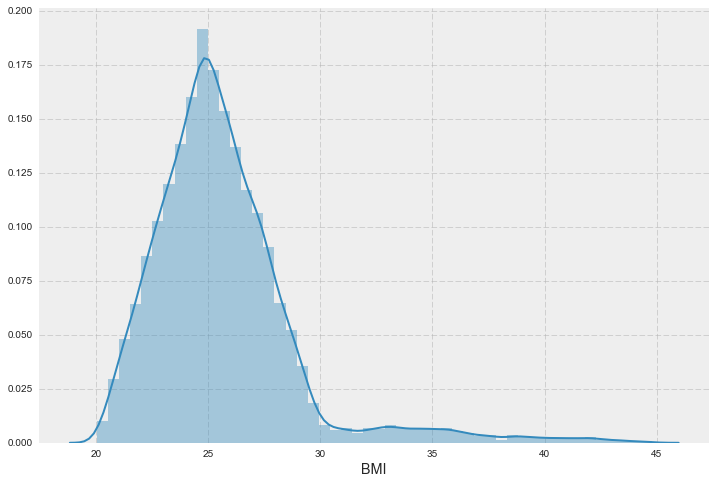

In [5]:
sns.distplot(df["BMI"])

Does the distribution if age look appropriate?

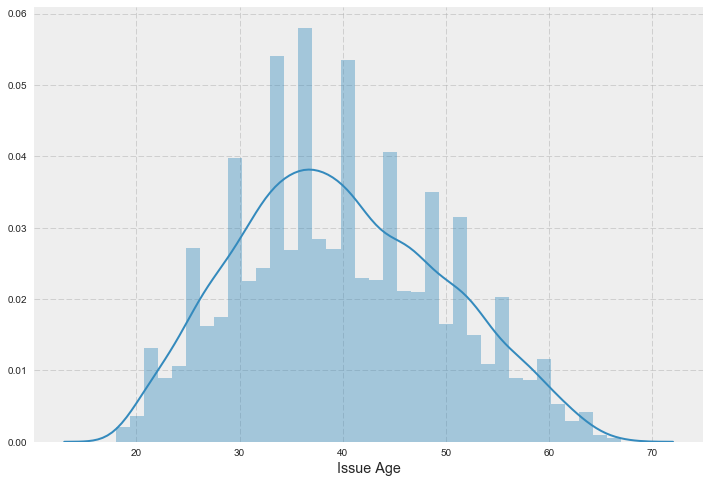

In [6]:
sns.distplot(df["Issue Age"])

Let's break down the proportion of cases with diabetes or high blood pressure by underwriting class.

In [7]:
df.pivot_table(index="Underwriting Class", values=["Diabetes", "High Blood Pressure"])

,Diabetes,High Blood Pressure
Underwriting Class,,
Decline,0.149000,0.190000
Standard,0.045556,0.030444


Let's try visualizing the distribution of the continuous variables and how they might relate to one another.

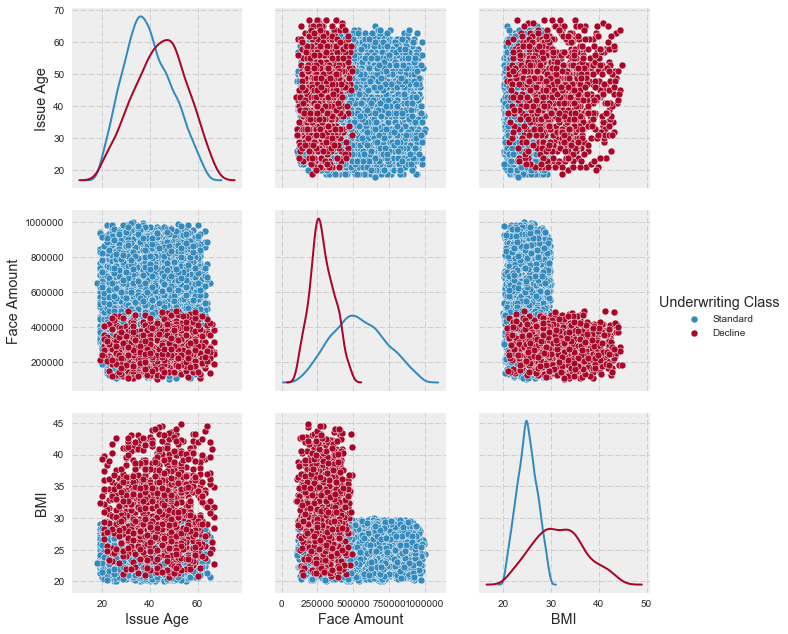

In [8]:
sns.pairplot(df[["Underwriting Class", "Issue Age", "Face Amount", "BMI"]], 
             hue="Underwriting Class", 
             diag_kind="kde", size=3)

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [10]:
features = ["Issue Age", "Face Amount", "BMI", "Diabetes", "High Blood Pressure"]
X = df[features]
y = df["Underwriting Class"]

### Let's try making some rules!

Based on the plots above, what rules should we create to identify a standard?

In [11]:
def ruleset(x):
    if x["Face Amount"] > 500000:
        return "Standard"
    if x["BMI"] > 30:
        return "Decline"
    if x["Diabetes"]:
        return "Decline"
    if x["High Blood Pressure"]:
        return "Decline"
    return "Standard"

In [12]:
rule_predictions = X.apply(ruleset, axis=1)

Accuracy might not always be the best metric. Since only 10% of cases are declined, by predicting all cases to be true we can get an accuracy of 90%.

In [13]:
print("Accuracy {0:.1f}%".format(100*accuracy_score(y, np.repeat("Standard", y.shape))))

Accuracy 90.0%


The accuracy from the rules based method is impressive.

In [14]:
print("Accuracy {0:.1f}%".format(100*accuracy_score(y, rule_predictions)))

Accuracy 94.2%


Looking at the confusion matrix allows us to see what the case actually was rated versus what the model predicts the case to be rated as. The columns represent the model prediction and the rows represent the underwriting outcome.

In [15]:
print("Confusion Matrix: ")
pd.DataFrame(confusion_matrix(y, rule_predictions), columns=["Decline", "Standard"], index=["Decline", "Standard"])

Confusion Matrix: 


,Decline,Standard
Decline,718,282
Standard,300,8700


## Building a decision tree

Now that we have a custom rules based model, let's see if we can use machine learning to automatically *learn* rules to classify the case. The model we will be using is called a **Decision Tree**. The way decision trees work, is by recursively creating rules to split the dataset until each split consists of mostly the same class.

In [16]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [17]:
clf = DecisionTreeClassifier(max_depth=4, min_impurity_split=.05)
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=0.05, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [18]:
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=0.05, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [19]:
predictions = clf.predict(X)

Now that we have our predictions, let's visualize how our decision tree looks like.

In [20]:
from PIL import Image
def visualize_tree(clf, features):
    with open("dt.dot", 'w') as f:
        export_graphviz(clf, out_file=f,
                        feature_names=features)
    !dot -Tpng dt.dot -o dt.png
    im = Image.open("dt.png")
    return im

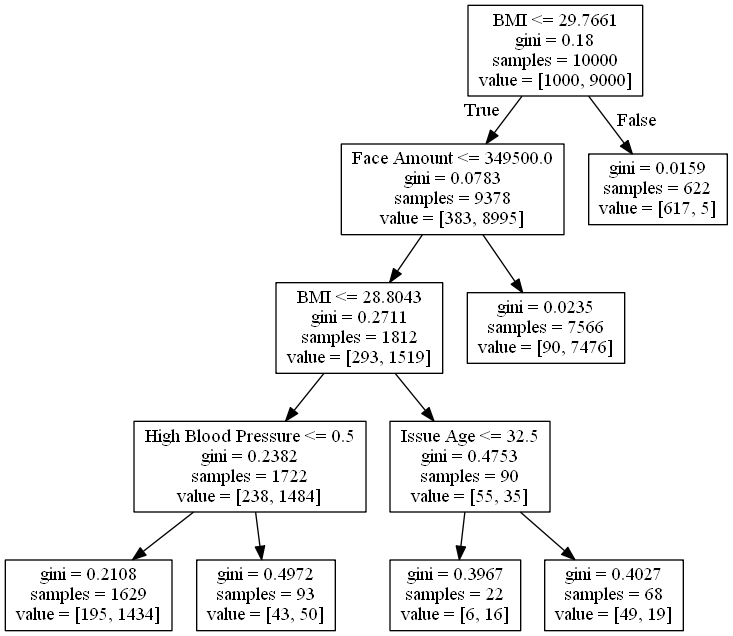

In [21]:
visualize_tree(clf, features)

Let's look at the accuracy of the custom rules versus the decision tree

In [22]:
print("Accuracy of custom rules: {0:.1f}%".format(100*accuracy_score(y, rule_predictions)))
print("Accuracy of decision tree: {0:.1f}%".format(100*accuracy_score(y, predictions)))

Accuracy of custom rules: 94.2%
Accuracy of decision tree: 96.4%


In [23]:
print("Confusion Matrix: ")
pd.DataFrame(confusion_matrix(y, predictions), columns=["Decline", "Standard"], index=["Decline", "Standard"])

Confusion Matrix: 


,Decline,Standard
Decline,666,334
Standard,24,8976


While the above performance metrics are useful, our best proxy for the performance of our model is on data the model has never seen before.

In [24]:
test = pd.read_csv("data/underwriting_data_test.csv")
test.set_index("Person ID", inplace=True)
X_test = test[features]
y_test = test["Underwriting Class"]
test_predictions = clf.predict(X_test)

In [25]:
print("Accuracy of custom rules: {0:.1f}%".format(100*accuracy_score(y_test, X_test.apply(ruleset, axis=1))))
print("Accuracy of decision tree: {0:.1f}%".format(100*accuracy_score(y_test, test_predictions)))

Accuracy of custom rules: 94.0%
Accuracy of decision tree: 96.1%


In [26]:
print("Confusion Matrix: ")
pd.DataFrame(confusion_matrix(y_test, test_predictions), columns=["Decline", "Standard"], index=["Decline", "Standard"])

Confusion Matrix: 


,Decline,Standard
Decline,654,346
Standard,46,8954


# Trying some different models
Now that we have a few baselines to compare to, let's try running a number of different models and choose the model that has the highest performance.

![Scikit Learn Model Cheatsheet](http://scikit-learn.org/stable/_static/ml_map.png)

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier

Some models require normalization of features, we can use `StandardScaler` for this.

In [28]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LinearSVC()),
])
pipeline

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

We can try a number of different models and hyperparameter configurations of these models.

In [29]:
parameters = [
    {
        'clf': (Lasso(),),
        'clf__alpha': (1e-4, 1e-3, 1e-1)
    }, {
        'clf': (LinearSVC(),),
        'clf__C': (0.01, 0.5, 1.0)
    }, {
        'scaler__with_mean': (False,),
        'scaler__with_std': (False,),
        'clf': (RandomForestClassifier(100),),
        'clf__min_samples_split': (2, 25, 100)
    }
]
param_descriptions = ["Lasso alpha=1e-4", 
                      "Lasso alpha=1e-3",
                      "Lasso alpha=1e-1",
                      "LinearSVC C=0.01",
                      "LinearSVC C=0.5",
                      "LinearSVC C=1.0", 
                      "RandomForest min_samples=2",
                      "RandomForest min_samples=25",
                      "RandomForest min_samples=100"
                    ]

In [30]:
glf = GridSearchCV(pipeline, parameters, scoring='roc_auc', cv=3)
glf

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'clf__alpha': (0.0001, 0.001, 0.1), 'clf': (Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),)}, {'clf__C': (0.01, 0.5, 1.0), 'clf': (LinearSVC(C...tors=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [31]:
y_n = y=="Standard"

In [32]:
glf.fit(X, y_n)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'clf__alpha': (0.0001, 0.001, 0.1), 'clf': (Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),)}, {'clf__C': (0.01, 0.5, 1.0), 'clf': (LinearSVC(C...tors=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [33]:
glf.cv_results_.keys()

dict_keys(['std_train_score', 'param_scaler__with_std', 'params', 'split2_test_score', 'split0_train_score', 'mean_train_score', 'std_score_time', 'rank_test_score', 'split2_train_score', 'split0_test_score', 'std_fit_time', 'mean_fit_time', 'param_scaler__with_mean', 'split1_train_score', 'split1_test_score', 'param_clf__C', 'mean_score_time', 'std_test_score', 'param_clf__min_samples_split', 'mean_test_score', 'param_clf__alpha', 'param_clf'])

Let's see what our evaluation metric looks like across the different models and hyper parameters.

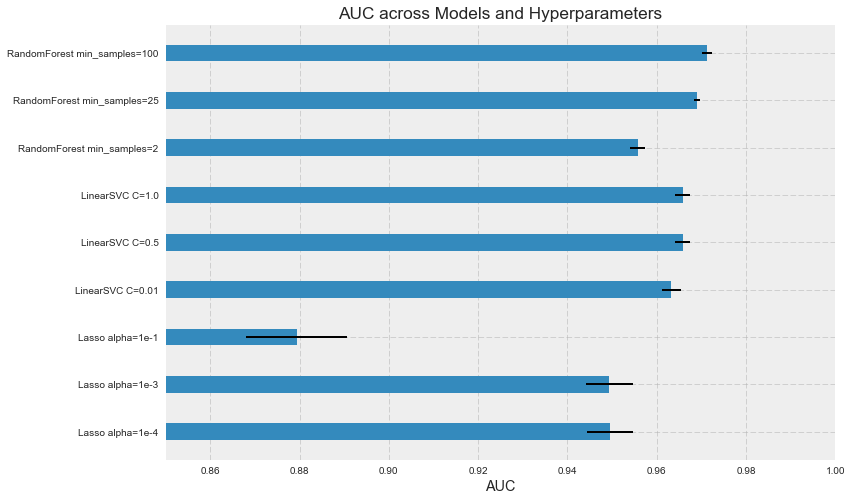

In [34]:
fig, ax = plt.subplots()
width = .35
ax.barh(range(len(glf.cv_results_["mean_test_score"])), 
         glf.cv_results_["mean_test_score"], 
         width,
         xerr = glf.cv_results_["std_test_score"], 
         tick_label=param_descriptions)

ax.set_xlim((.85, 1.0))
ax.set_title("AUC across Models and Hyperparameters")
ax.set_xlabel("AUC")

The best model is the random forest with a minimum number of samples of 100 in order to continue splitting a leaf.

While the evaluation metric might be good, let's look at how long the models took to train on historical cases and generate predictions on new cases.

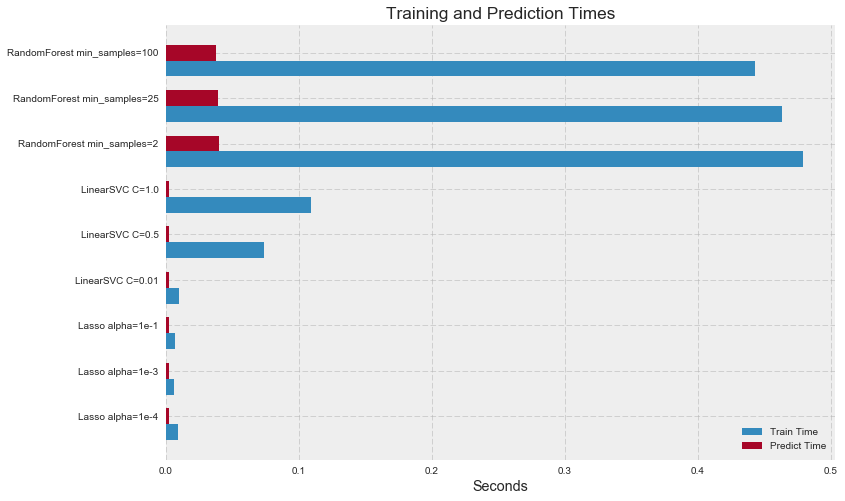

In [35]:
fig, ax = plt.subplots()
width = .35
rects1 = ax.barh(range(len(glf.cv_results_["mean_fit_time"])), 
         glf.cv_results_["mean_fit_time"], 
         width,
         tick_label=param_descriptions)
rects2 = ax.barh(np.arange(len(glf.cv_results_["mean_fit_time"])) + width, 
         glf.cv_results_["mean_score_time"], 
         width,
         tick_label=param_descriptions)

ax.set_title("Training and Prediction Times")
ax.set_xlabel("Seconds")
ax.legend((rects1[0], rects2[0]), ('Train Time', 'Predict Time'))

In [36]:
glf.cv_results_["mean_fit_time"] / glf.cv_results_["mean_fit_time"][5]

array([ 0.08536546,  0.05487624,  0.06097627,  0.08841475,  0.6768295 ,
        1.        ,  4.38414459,  4.23780431,  4.05182841])

It takes 5 times the amount of time to train and 17 times the amount of time to generate a prediction for our best model compared with the LinearSVC with C=1.0, whereas the improvement for our evaluation metric is marginal.

We can do a final comparison of our decision tree with the estimator that had the best evaluation metric.

In [37]:
print("Confusion Matrix for decision tree: ")
pd.DataFrame(confusion_matrix(y_test, test_predictions), columns=["Decline", "Standard"], index=["Decline", "Standard"])

Confusion Matrix for decision tree: 


,Decline,Standard
Decline,654,346
Standard,46,8954


In [38]:
print("Confusion Matrix for random forest: ")
rf_predictions = glf.predict(X_test)
rf_predictions = ["Standard" if x else "Decline" for x in rf_predictions]

pd.DataFrame(confusion_matrix(y_test, rf_predictions), columns=["Decline", "Standard"], index=["Decline", "Standard"])

Confusion Matrix for random forest: 


,Decline,Standard
Decline,681,319
Standard,32,8968
